<a href="https://colab.research.google.com/github/cepdnaclk/e19-co544-Bitcoin-Cost-Forecast-System/blob/main/Multivariate_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [1]:
import yfinance as yf
import pandas as pd

# Define the ticker simbol for Bitcoin
ticker = 'BTC-USD'

# Get historical market data
hist = yf.Ticker(ticker).history(period="max")

# Making the 'Date' as the index
hist.index = pd.to_datetime(hist.index)

# Drop the "Dividends" column and "Stock Splits" column
hist.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)

# Print the data
print(hist.head())

                                 Open        High         Low       Close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             Volume  
Date                                 
2014-09-17 00:00:00+00:00  21056800  
2014-09-18 00:00:00+00:00  34483200  
2014-09-19 00:00:00+00:00  37919700  
2014-09-20 00:00:00+00:00  36863600  
2014-09-21 00:00:00+00:00  26580100  


# Set Inputs and Outputs

In [2]:
X, y = hist.drop(columns = ['Close']), hist.Close.values
X.shape, y.shape

((3528, 4), (3528,))

## Standardize Features

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

## Split a multivariate sequence past, future samples (X abd y)

In [4]:
import numpy as np

# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):

    X, y = list(), list() # instantiate X and y

    for i in range(len(input_sequences)):

        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break

        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)

    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(3380, 100, 4) (3380, 50)


## Check the y_mm sample

In [5]:
print("y_mm[0]:", y_mm[0])
print("y_trans[99:149].squeeze(1):", y_trans[99:149].squeeze(1))

assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

y_mm[0]

y_mm[0]: [0.00193271 0.00205501 0.00188957 0.00190845 0.00184578 0.00181926
 0.00194896 0.00186743 0.00187817 0.0014125  0.00118087 0.00132186
 0.00148255 0.00159431 0.0014436  0.00154042 0.00132628 0.00120097
 0.00123027 0.00065507 0.         0.00043537 0.00041141 0.0002902
 0.00044216 0.00050419 0.00045555 0.00066928 0.00075856 0.00075133
 0.00095664 0.00103717 0.00130813 0.001171   0.00076554 0.00076003
 0.0006628  0.00053989 0.00067031 0.00082471 0.00067437 0.00066867
 0.00053505 0.00060576 0.00068103 0.00062148 0.00057619 0.00057247
 0.0005635  0.00059887]
y_trans[99:149].squeeze(1): [0.00193271 0.00205501 0.00188957 0.00190845 0.00184578 0.00181926
 0.00194896 0.00186743 0.00187817 0.0014125  0.00118087 0.00132186
 0.00148255 0.00159431 0.0014436  0.00154042 0.00132628 0.00120097
 0.00123027 0.00065507 0.         0.00043537 0.00041141 0.0002902
 0.00044216 0.00050419 0.00045555 0.00066928 0.00075856 0.00075133
 0.00095664 0.00103717 0.00130813 0.001171   0.00076554 0.00076003
 0.

array([0.00193271, 0.00205501, 0.00188957, 0.00190845, 0.00184578,
       0.00181926, 0.00194896, 0.00186743, 0.00187817, 0.0014125 ,
       0.00118087, 0.00132186, 0.00148255, 0.00159431, 0.0014436 ,
       0.00154042, 0.00132628, 0.00120097, 0.00123027, 0.00065507,
       0.        , 0.00043537, 0.00041141, 0.0002902 , 0.00044216,
       0.00050419, 0.00045555, 0.00066928, 0.00075856, 0.00075133,
       0.00095664, 0.00103717, 0.00130813, 0.001171  , 0.00076554,
       0.00076003, 0.0006628 , 0.00053989, 0.00067031, 0.00082471,
       0.00067437, 0.00066867, 0.00053505, 0.00060576, 0.00068103,
       0.00062148, 0.00057619, 0.00057247, 0.0005635 , 0.00059887])

In [6]:
y_trans[99:149].squeeze(1)

array([0.00193271, 0.00205501, 0.00188957, 0.00190845, 0.00184578,
       0.00181926, 0.00194896, 0.00186743, 0.00187817, 0.0014125 ,
       0.00118087, 0.00132186, 0.00148255, 0.00159431, 0.0014436 ,
       0.00154042, 0.00132628, 0.00120097, 0.00123027, 0.00065507,
       0.        , 0.00043537, 0.00041141, 0.0002902 , 0.00044216,
       0.00050419, 0.00045555, 0.00066928, 0.00075856, 0.00075133,
       0.00095664, 0.00103717, 0.00130813, 0.001171  , 0.00076554,
       0.00076003, 0.0006628 , 0.00053989, 0.00067031, 0.00082471,
       0.00067437, 0.00066867, 0.00053505, 0.00060576, 0.00068103,
       0.00062148, 0.00057619, 0.00057247, 0.0005635 , 0.00059887])

## Split Training & Test Sets

In [7]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (3230, 100, 4) (3230, 50)
Testing Shape: (150, 100, 4) (150, 50)


## Convert Data Into Tensors

In [8]:
import torch

# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train).requires_grad_(True)
X_test_tensors = torch.Tensor(X_test).requires_grad_(True)

y_train_tensors = torch.Tensor(y_train).requires_grad_(True)
y_test_tensors = torch.Tensor(y_test).requires_grad_(True)


## Reshaping to rows, timestamps, features

In [9]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 100,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 100,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([3230, 100, 4]) torch.Size([3230, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


In [10]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

X.iloc[-149:-145]

,Open,High,Low,Volume
Date,,,,
2023-12-18 00:00:00+00:00,41348.203125,42720.296875,40530.257812,25224642008
2023-12-19 00:00:00+00:00,42641.511719,43354.296875,41826.335938,23171001281
2023-12-20 00:00:00+00:00,42261.300781,44275.585938,42223.816406,27868908174
2023-12-21 00:00:00+00:00,43648.125000,44240.667969,43330.050781,22452766169


In [11]:
y_check[-1]

array([69987.8359375 , 69455.34375   , 70744.953125  , 69892.828125  ,
       69645.3046875 , 71333.6484375 , 69702.1484375 , 65446.97265625,
       65980.8125    , 68508.84375   , 67837.640625  , 68896.109375  ,
       69362.5546875 , 71631.359375  , 69139.015625  , 70587.8828125 ,
       70060.609375  , 67195.8671875 , 63821.47265625, 65738.7265625 ,
       63426.2109375 , 63811.86328125, 61276.69140625, 63512.75390625,
       63843.5703125 , 64994.44140625, 64926.64453125, 66837.6796875 ,
       66407.2734375 , 64276.8984375 , 64481.70703125, 63755.3203125 ,
       63419.140625  , 63113.23046875, 63841.12109375, 60636.85546875,
       58254.01171875, 59123.43359375, 62889.8359375 , 63891.47265625,
       64031.1328125 , 63161.94921875, 62334.81640625, 61187.94140625,
       63049.9609375 , 60792.77734375, 60793.7109375 , 61448.39453125,
       62901.44921875, 61880.41796875])

In [12]:
hist.Close.values[-1:]

array([61880.41796875])

# LSTM Model

In [13]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

# Training

In [14]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))

# Instance of a LSTM Model

In [15]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

# Training Loop

In [16]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)



Epoch: 0, train loss: 0.13473, test loss: 0.54105
Epoch: 100, train loss: 0.00697, test loss: 0.03869
Epoch: 200, train loss: 0.00524, test loss: 0.03263
Epoch: 300, train loss: 0.00343, test loss: 0.02866
Epoch: 400, train loss: 0.00300, test loss: 0.02667
Epoch: 500, train loss: 0.00280, test loss: 0.02550
Epoch: 600, train loss: 0.00269, test loss: 0.02423
Epoch: 700, train loss: 0.00264, test loss: 0.02341
Epoch: 800, train loss: 0.00262, test loss: 0.02285
Epoch: 900, train loss: 0.00261, test loss: 0.02265


# Prediction

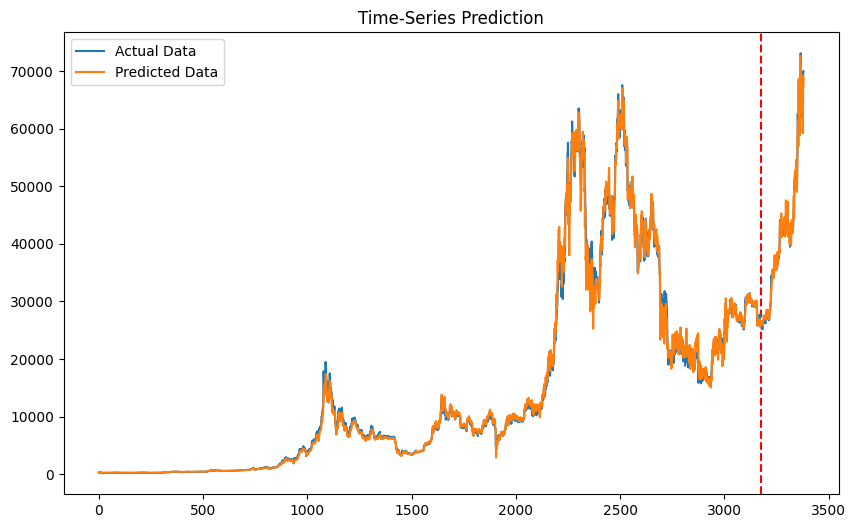

In [17]:
import matplotlib.pyplot as plt

df_X_ss = ss.transform(hist.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(hist.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation

dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])


plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()



# Bitcoin Price for Tommorrow

In [18]:
# Assuming df_X_ss and lstm are already defined and lstm is trained
# Get the last batch of the recent 100 days data
last_batch = df_X_ss[-1].reshape((1, 100, df_X_ss.shape[2]))

# Convert to tensor
last_batch_tensor = torch.Tensor(last_batch)

# Get the prediction
with torch.no_grad():
    lstm.eval()
    predicted_price_tensor = lstm(last_batch_tensor)
    predicted_price_numpy = predicted_price_tensor.data.numpy()

# Reverse the MinMax scaling
predicted_price = mm.inverse_transform(predicted_price_numpy)
print(f"Predicted Bitcoin price for tomorrow: {predicted_price[0][0]}")

Predicted Bitcoin price for tomorrow: 67347.5703125


# Model Evaluation

## Test Loss

In [19]:
import torch

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        predictions = model(X_test)
        # Calculate the loss
        loss_fn = torch.nn.MSELoss()
        loss = loss_fn(predictions, y_test)
    return loss.item()

# Call the evaluate_model function
test_loss = evaluate_model(lstm, X_test_tensors_final, y_test_tensors)
print(f"Test Loss: {test_loss}")


Test Loss: 0.0225305687636137


## MAE

In [28]:
import torch
from torch.nn.functional import l1_loss

# 'predictions' and 'true_values' are PyTorch tensors of the same shape
predictions = lstm(X_test_tensors_final)
true_values = y_test_tensors

# Calculate MAE
mae = l1_loss(predictions, true_values, reduction='mean').item()
print(f"Mean Absolute Error: {mae}")



Mean Absolute Error: 0.10730067640542984


## R-squared

In [23]:
from sklearn.metrics import r2_score

# lstm and X_test_tensors_final are already defined and lstm is trained
lstm.eval()  # Set the model to evaluation mode
y_pred = lstm(X_test_tensors_final)
y_pred_numpy = y_pred.data.numpy()

# y_test_tensors is the actual values tensor and mm is the MinMaxScaler
y_test_numpy = y_test_tensors.data.numpy()

# Inverse transform the scaled data to original scale
y_pred_rescaled = mm.inverse_transform(y_pred_numpy)
y_test_rescaled = mm.inverse_transform(y_test_numpy)

# Calculate R-squared
r_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared: {r_squared}")




R-squared: 0.07209295588349238


## MAPE

In [24]:
import torch

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps=1e-8):
    # Avoid division by zero
    y_true, y_pred = torch.tensor(y_true), torch.tensor(y_pred)
    mape = torch.mean(torch.abs((y_true - y_pred) / torch.clamp(y_true, min=eps)))
    return mape

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        predictions = model(X_test)
        # Calculate the MAPE
        mape = mean_absolute_percentage_error(y_test, predictions)
    return mape.item()

# Call the evaluate_model function
test_mape = evaluate_model(lstm, X_test_tensors_final, y_test_tensors)
print(f"Test MAPE: {test_mape}")


Test MAPE: 0.13229183852672577
